# Import libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import tensorflow_datasets as tfds
import numpy as np
import sklearn as sk
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

# check Tensorflow version
print(tf.version.VERSION)

2.8.0


# A few tricks to make Tensorflow Datasets work

In [2]:
# !pip install tensorflow_datasets ipywidgets

In [3]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


# Dataset functions

In [4]:
def process_image(example):
    image, label = example['image'], example['label']
    # Normalize images to have a mean of 0 and standard deviation of 1
    image = tf.image.per_image_standardization(image)
    # Resize images to 224x224
    image = tf.image.resize(image, (224,224))
    return image, label

def build_dataset(path):
    builder = tfds.folder_dataset.ImageFolder(path)
    # print(builder.info)

    train_ds = builder.as_dataset(split='train', shuffle_files=True)
    valid_ds = builder.as_dataset(split='valid', shuffle_files=False)
    
    
    train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
    valid_ds_size = tf.data.experimental.cardinality(valid_ds).numpy()
    
    print("Training data size:", train_ds_size)
    print("Validation data size:", valid_ds_size)
    tfds.show_examples(train_ds, builder.info)

    BATCH_SIZE = 32
    train_ds = (train_ds
                      .map(process_image)
                      .shuffle(buffer_size=train_ds_size)
                      .batch(batch_size=BATCH_SIZE, drop_remainder=True))

    valid_ds = (valid_ds
                      .map(process_image)
                      .batch(batch_size=BATCH_SIZE, drop_remainder=False))
    
    
    return (train_ds, valid_ds)

# Prepare the Orchid-52 dataset

Training data size: 2403
Validation data size: 780


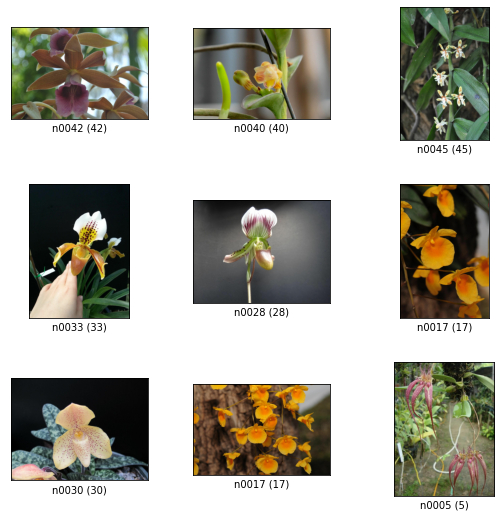

In [5]:
train_ds, valid_ds = build_dataset('orchid/')

# Metrics function

![Metrics](metrics.png)

In [6]:
def get_metrics(predicted, actual):
    TP = tf.math.count_nonzero(predicted * actual)
    TN = tf.math.count_nonzero((predicted - 1) * (actual - 1))
    FP = tf.math.count_nonzero(predicted * (actual - 1))
    FN = tf.math.count_nonzero((predicted - 1) * actual)

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)
    accuracy = (TP + TN) / (TP + FN + TN + FP)
    specificity = TN / (TN + FP)

    return (precision, recall, f1, accuracy, specificity)

In [7]:
def vectorize(labels, num_classes):
    """Return a 2-dimensional tensor with the second vector
    consisting of 10-dimensional unit vector with a 1.0 in the jth
    position and zeroes elsewhere. This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    result = np.zeros((len(labels), num_classes, 1), dtype=np.uint8)
    for i in range(len(labels)):
        j = labels[i]
        result[i, j] = 1
    return result

# Evaluate ResNet on Orchid 52 classes

In [8]:
# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model('train_52c/resnet_0_52c_100e.h5')
# model.summary()
best_epochs = [36,59,52]
metrics = []
metrics_sk = []

for i in range(3):
    model.load_weights(f"train_52c/resnet_{i}_52c_100e/cp-00{best_epochs[i]}.ckpt")
    
    y = np.concatenate([y for x, y in valid_ds], axis=0)
    y_pred = np.argmax(model.predict(valid_ds, verbose=2), axis=1)
    
    y = y.astype(int)
    y_pred = y_pred.astype(int)
    acc = np.sum(y_pred == y)/y.shape[0]
    predicted = vectorize(y_pred, np.max(y)+1)
    actual = vectorize(y, np.max(y)+1)
    (precision, recall, f1, accuracy, specificity) = get_metrics(predicted, actual)
    metrics.append((acc, precision, recall, f1, accuracy, specificity))
    
    (precision, recall, fscore, support) = precision_recall_fscore_support(y, y_pred, average='micro')
    conf_mat = confusion_matrix(y, y_pred)
    metrics_sk.append((precision, recall, fscore, support, conf_mat))

25/25 - 176s - 176s/epoch - 7s/step
25/25 - 177s - 177s/epoch - 7s/step
25/25 - 164s - 164s/epoch - 7s/step


In [9]:
metrics

[(0.7371794871794872,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.7371794871794872>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.7371794871794872>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.7371794871794872>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.9898915187376726>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.9948466566113625>),
 (0.8179487179487179,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.8179487179487179>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.8179487179487179>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.8179487179487179>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.9929980276134123>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.9964303670186023>),
 (0.7692307692307693,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.7692307692307693>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.7692307692307693>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.7692307692307693>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.9911242603550295>,
  <tf.Te

In [10]:
np.mean(metrics, axis=0)

array([0.77478632, 0.77478632, 0.77478632, 0.77478632, 0.99133794,
       0.99558405])

In [11]:
metrics_sk

[(0.7371794871794872,
  0.7371794871794872,
  0.7371794871794872,
  None,
  array([[12,  1,  0, ...,  0,  0,  0],
         [ 0, 12,  0, ...,  0,  0,  0],
         [ 0,  0,  8, ...,  0,  0,  1],
         ...,
         [ 0,  0,  0, ...,  9,  0,  0],
         [ 0,  0,  0, ...,  0, 13,  0],
         [ 0,  0,  0, ...,  0,  0, 10]], dtype=int64)),
 (0.8179487179487179,
  0.8179487179487179,
  0.8179487179487179,
  None,
  array([[13,  0,  0, ...,  0,  0,  1],
         [ 0, 14,  0, ...,  0,  0,  0],
         [ 0,  0,  9, ...,  0,  0,  0],
         ...,
         [ 0,  0,  0, ..., 12,  0,  0],
         [ 0,  0,  0, ...,  0, 13,  0],
         [ 0,  0,  0, ...,  0,  0, 10]], dtype=int64)),
 (0.7692307692307693,
  0.7692307692307693,
  0.7692307692307693,
  None,
  array([[13,  1,  0, ...,  0,  0,  0],
         [ 0, 12,  0, ...,  0,  0,  0],
         [ 0,  0, 10, ...,  0,  0,  0],
         ...,
         [ 0,  1,  0, ...,  9,  0,  0],
         [ 0,  0,  0, ...,  0, 14,  0],
         [ 0,  0,  0, ..

# Evaluate DenseNet on Orchid 52 classes

In [12]:
# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model('train_52c/densenet_0_52c_100e.h5')
# model.summary()
best_epochs = [98,95,88]
metrics = []
metrics_sk = []

for i in range(3):
    model.load_weights(f"train_52c/densenet_{i}_52c_100e/cp-00{best_epochs[i]}.ckpt")
    
    y = np.concatenate([y for x, y in valid_ds], axis=0)
    y_pred = np.argmax(model.predict(valid_ds, verbose=2), axis=1)
    
    y = y.astype(int)
    y_pred = y_pred.astype(int)
    acc = np.sum(y_pred == y)/y.shape[0]
    predicted = vectorize(y_pred, np.max(y)+1)
    actual = vectorize(y, np.max(y)+1)
    (precision, recall, f1, accuracy, specificity) = get_metrics(predicted, actual)
    metrics.append((acc, precision, recall, f1, accuracy, specificity))
    
    (precision, recall, fscore, support) = precision_recall_fscore_support(y, y_pred, average='micro')
    conf_mat = confusion_matrix(y, y_pred)
    metrics_sk.append((precision, recall, fscore, support, conf_mat))

25/25 - 82s - 82s/epoch - 3s/step
25/25 - 79s - 79s/epoch - 3s/step
25/25 - 79s - 79s/epoch - 3s/step


In [13]:
metrics

[(0.9153846153846154,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.9153846153846154>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.9153846153846154>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.9153846153846154>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.9967455621301775>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.998340874811463>),
 (0.9064102564102564,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.9064102564102564>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.9064102564102564>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.9064102564102564>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.9964003944773175>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.9981649069884364>),
 (0.9115384615384615,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.9115384615384615>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.9115384615384615>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.9115384615384615>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.9965976331360947>,
  <tf.Ten

In [14]:
np.mean(metrics, axis=0)

array([0.91111111, 0.91111111, 0.91111111, 0.91111111, 0.9965812 ,
       0.99825708])

In [15]:
metrics_sk

[(0.9153846153846154,
  0.9153846153846154,
  0.9153846153846154,
  None,
  array([[15,  0,  0, ...,  0,  0,  0],
         [ 0, 14,  0, ...,  0,  0,  0],
         [ 0,  0, 14, ...,  0,  0,  0],
         ...,
         [ 0,  0,  0, ..., 14,  0,  0],
         [ 0,  0,  0, ...,  0, 15,  0],
         [ 0,  0,  0, ...,  0,  0, 14]], dtype=int64)),
 (0.9064102564102564,
  0.9064102564102564,
  0.9064102564102564,
  None,
  array([[14,  0,  1, ...,  0,  0,  0],
         [ 0, 14,  0, ...,  0,  0,  0],
         [ 0,  0, 12, ...,  0,  0,  0],
         ...,
         [ 0,  1,  0, ..., 12,  0,  0],
         [ 0,  0,  0, ...,  0, 15,  0],
         [ 0,  0,  0, ...,  0,  0, 14]], dtype=int64)),
 (0.9115384615384615,
  0.9115384615384615,
  0.9115384615384615,
  None,
  array([[15,  0,  0, ...,  0,  0,  0],
         [ 0, 14,  0, ...,  0,  0,  0],
         [ 0,  0, 12, ...,  0,  0,  0],
         ...,
         [ 0,  0,  0, ..., 14,  0,  0],
         [ 0,  0,  0, ...,  0, 15,  0],
         [ 0,  0,  0, ..

# Prepare the Orchid-219 dataset

Training data size: 1533
Validation data size: 657


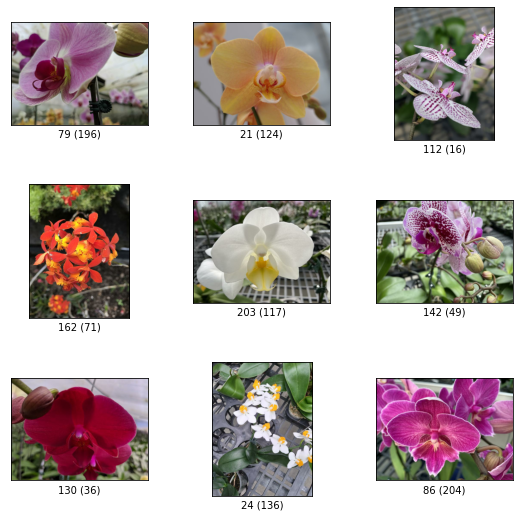

In [16]:
train_ds, valid_ds = build_dataset('training/')

# Evaluate ResNet on Orchid 219 classes

In [17]:
# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model('train_219c/resnet_0_219c_100e.h5')
# model.summary()
best_epochs = [51,57,74]
metrics = []
metrics_sk = []

for i in range(3):
    model.load_weights(f"train_219c/resnet_{i}_219c_100e/cp-00{best_epochs[i]}.ckpt")
    
    y = np.concatenate([y for x, y in valid_ds], axis=0)
    y_pred = np.argmax(model.predict(valid_ds, verbose=2), axis=1)
    
    y = y.astype(int)
    y_pred = y_pred.astype(int)
    acc = np.sum(y_pred == y)/y.shape[0]
    predicted = vectorize(y_pred, np.max(y)+1)
    actual = vectorize(y, np.max(y)+1)
    (precision, recall, f1, accuracy, specificity) = get_metrics(predicted, actual)
    metrics.append((acc, precision, recall, f1, accuracy, specificity))
    
    (precision, recall, fscore, support) = precision_recall_fscore_support(y, y_pred, average='micro')
    conf_mat = confusion_matrix(y, y_pred)
    metrics_sk.append((precision, recall, fscore, support, conf_mat))

21/21 - 136s - 136s/epoch - 6s/step
21/21 - 133s - 133s/epoch - 6s/step
21/21 - 132s - 132s/epoch - 6s/step


In [18]:
metrics

[(0.2785388127853881,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.2785388127853881>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.2785388127853881>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.2785388127853881>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.9934113133587706>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.996690545012777>),
 (0.2678843226788432,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.2678843226788432>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.2678843226788432>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.2678843226788432>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.9933140120792588>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.9966416712049488>),
 (0.2907153729071537,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.2907153729071537>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.2907153729071537>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.2907153729071537>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.9935225148210699>,
  <tf.Ten

In [19]:
np.mean(metrics, axis=0)

array([0.27904617, 0.27904617, 0.27904617, 0.27904617, 0.99341595,
       0.99669287])

In [20]:
metrics_sk

[(0.2785388127853881,
  0.2785388127853881,
  0.2785388127853881,
  None,
  array([[2, 0, 0, ..., 0, 0, 0],
         [0, 1, 0, ..., 0, 0, 0],
         [0, 0, 1, ..., 0, 0, 0],
         ...,
         [1, 0, 0, ..., 1, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 2]], dtype=int64)),
 (0.2678843226788432,
  0.2678843226788432,
  0.2678843226788432,
  None,
  array([[2, 0, 0, ..., 0, 0, 0],
         [0, 2, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [2, 0, 0, ..., 1, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 2]], dtype=int64)),
 (0.2907153729071537,
  0.2907153729071537,
  0.2907153729071537,
  None,
  array([[3, 0, 0, ..., 0, 0, 0],
         [0, 3, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [1, 0, 0, ..., 1, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 2]], dtype=int64))]

# Evaluate DenseNet on Orchid 219 classes

In [21]:
# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model('train_219c/densenet_0_219c_100e.h5')
# model.summary()
best_epochs = ['093','100','099']
metrics = []
metrics_sk = []

for i in range(3):
    model.load_weights(f"train_219c/densenet_{i}_219c_100e/cp-0{best_epochs[i]}.ckpt")
    
    y = np.concatenate([y for x, y in valid_ds], axis=0)
    y_pred = np.argmax(model.predict(valid_ds, verbose=2), axis=1)
    
    y = y.astype(int)
    y_pred = y_pred.astype(int)
    acc = np.sum(y_pred == y)/y.shape[0]
    predicted = vectorize(y_pred, np.max(y)+1)
    actual = vectorize(y, np.max(y)+1)
    (precision, recall, f1, accuracy, specificity) = get_metrics(predicted, actual)
    metrics.append((acc, precision, recall, f1, accuracy, specificity))
    
    (precision, recall, fscore, support) = precision_recall_fscore_support(y, y_pred, average='micro')
    conf_mat = confusion_matrix(y, y_pred)
    metrics_sk.append((precision, recall, fscore, support, conf_mat))

21/21 - 66s - 66s/epoch - 3s/step
21/21 - 63s - 63s/epoch - 3s/step
21/21 - 63s - 63s/epoch - 3s/step


In [22]:
metrics

[(0.4535768645357686,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.4535768645357686>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.4535768645357686>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.4535768645357686>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.9950098343793221>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.9974934718556686>),
 (0.4855403348554033,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.4855403348554033>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.4855403348554033>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.4855403348554033>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.9953017382178576>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.9976400932791533>),
 (0.4764079147640791,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.4764079147640791>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.4764079147640791>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.47640791476407907>,
  <tf.Tensor: shape=(), dtype=float64, numpy=0.9952183371211332>,
  <tf.T

In [23]:
np.mean(metrics, axis=0)

array([0.4718417 , 0.4718417 , 0.4718417 , 0.4718417 , 0.99517664,
       0.99757726])

In [24]:
metrics_sk

[(0.4535768645357686,
  0.4535768645357686,
  0.4535768645357686,
  None,
  array([[2, 0, 0, ..., 0, 0, 0],
         [0, 2, 0, ..., 0, 0, 0],
         [0, 0, 1, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 3, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 3]], dtype=int64)),
 (0.4855403348554033,
  0.4855403348554033,
  0.4855403348554033,
  None,
  array([[3, 0, 0, ..., 0, 0, 0],
         [0, 1, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 3, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 3]], dtype=int64)),
 (0.4764079147640791,
  0.4764079147640791,
  0.47640791476407907,
  None,
  array([[2, 0, 0, ..., 0, 0, 0],
         [0, 1, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 3, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 2]], dtype=int64))]